# Bitpattern histograms for scaled ShallowWaters

In [1]:
using Sherlogs, ShallowWaters, PyPlot, BFloat16s, FileIO, JLD2

In [3]:
# spin-up
# run_model(nx=200,Ndays=1000,output=true,output_dt=240,scale=1,scale_sst=1);

Starting ShallowWaters run 0 on Tue, 04 May 2021 13:53:50
Model integration will take approximately 29.0s,
and is hopefully done on Tue, 04 May 2021 13:54:19
1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%64%65%66%67%68%69%70%71%72%73%74%75%76%77%78%79%80%81%82%83%84%85%86%87%88%89%90%91%92%93%94%95%96%97%98%99%100% Integration done in 30.8s.
All data stored.


In [2]:
reset_logbook(1)
P_unscaled = run_model(Sherlog16{Float16,1},nx=200,Ndays=200,scale=1,scale_η=1,scale_sst=1,
    initial_cond="ncfile",init_run_id=0);

Starting ShallowWaters on Wed, 16 Jun 2021 14:37:17 without output.
100% Integration done in 1min, 39s.


In [54]:
reset_logbook(2)
P_scaled = run_model(Sherlog16{Float16,2},nx=200,Ndays=200,scale=2^6,scale_η=1,scale_sst=2^15,compensated=false,
    initial_cond="ncfile",init_run_id=0);

Starting ShallowWaters on Wed, 16 Jun 2021 15:08:57 without output.
100% Integration done in 1min, 37s.


In [4]:
reset_logbook(3)
P_f32 = run_model(Sherlog32{BFloat16,3},nx=200,Ndays=200,scale=1,scale_sst=1,initial_cond="ncfile",init_run_id=0);

Starting ShallowWaters on Wed, 16 Jun 2021 14:43:50 without output.
100% Integration done in 1min, 17s.


In [5]:
reset_logbook(4)
P_f32s = run_model(Sherlog32{BFloat16,4},nx=200,Ndays=200,scale=2^6,scale_sst=2^15,initial_cond="ncfile",init_run_id=0);

Starting ShallowWaters on Wed, 16 Jun 2021 14:45:15 without output.
100% Integration done in 1min, 17s.


In [6]:
function Base.sort(lb::LogBook)
    @views positives = lb.logbook[1:2^15]
    @views negatives = lb.logbook[2^15+1:end]
    lb_sorted = vcat(reverse(negatives),positives)
    return LogBook(lb_sorted)
end

function uint16_sort(x::Union{Float16,BFloat16})
    ui = reinterpret(UInt16,x)
    return signbit(x) ? 0x8000 - (ui - 0x7fff) : ui + 0x8000
end

uint16_sort (generic function with 1 method)

In [55]:
lbs = get_logbooks()
lb1 = sort(lbs[1]).logbook
lb2 = sort(lbs[2]).logbook
lb3 = sort(lbs[3]).logbook
lb4 = sort(lbs[4]).logbook

@load "logbook_bf16_dimful.jld2" lb_f32d
lb5 = sort(lb_f32d).logbook;

In [56]:
f16_posrange = uint16_sort.([BFloat16(Float32(reinterpret(Float16,0x0001))),
                            BFloat16(Float32(reinterpret(Float16,0x7bfe)))])
f16_negrange = uint16_sort.([-BFloat16(Float32(reinterpret(Float16,0x0001))),
                            -BFloat16(Float32(reinterpret(Float16,0x7bfe)))])
(sum(Int64,lb5[f16_posrange[1]:f16_posrange[2]])+sum(Int64,lb5[f16_negrange[2]:f16_negrange[1]]))/sum(lb5)

0.8831881352741997

In [64]:
# count subnormals
subnormals_pos = 2^15 .+ collect(2:1024)    # sorted logbook, index 2^15+1 = +0
subnormals_neg = 2^15 .- collect(1:1023)    # sorted logbook, index 2^15   = -0
subnormals_all = vcat(subnormals_pos,subnormals_neg)
n_subnormals1 = round(sum(lb1[subnormals_all])/sum(lb1)*100,digits=2)
n_subnormals2 = round(sum(lb2[subnormals_all])/sum(lb2)*100,digits=2)

0.04

In [65]:
# smoothing?
nsmooth = 128

lb1s = copy(lb1)
lb2s = copy(lb2)
lb3s = copy(lb3)
lb4s = copy(lb4)
lb5s = copy(lb5)

for i in 2:length(lb1)-(nsmooth-1)
    lb1s[i] = round(1/nsmooth*sum(lb1[i:i+nsmooth-1]))
    lb2s[i] = round(1/nsmooth*sum(lb2[i:i+nsmooth-1]))
    lb3s[i] = round(1/nsmooth*sum(lb3[i:i+nsmooth-1]))
    lb4s[i] = round(1/nsmooth*sum(lb4[i:i+nsmooth-1]))
    lb5s[i] = round(1/nsmooth*sum(lb5[i:i+nsmooth-1]))
end

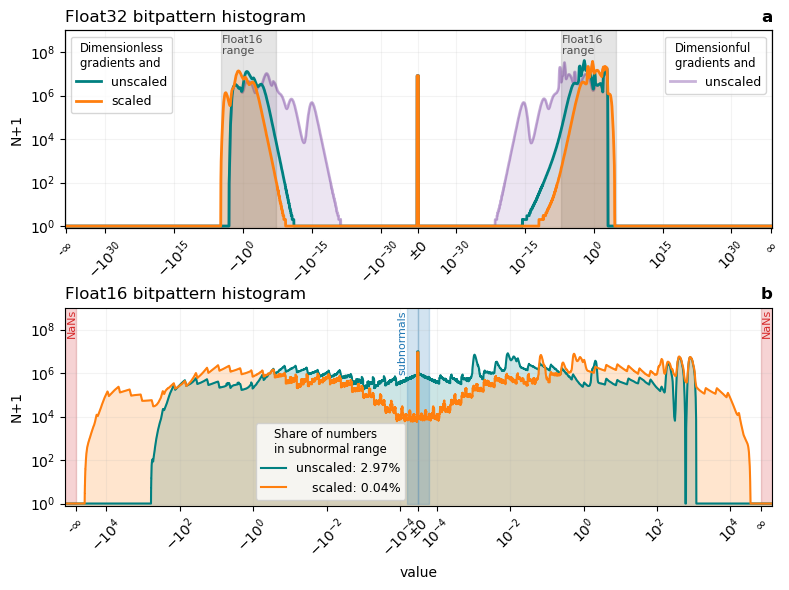

In [66]:
s1,s2 = 15,30
tiks_bf16 = [-Inf,-10.0^s2,-10.0^s1,-1,-10.0^-s1,-10.0^-s2,0.0,10.0^-s2,10.0^-s1,1,10.0^s1,10.0^s2,Inf]
labels_bf16 = ["-∞",L"-10^{%$s2}",L"-10^{%$s1}",L"-10^0",L"-10^{-%$s1}",L"-10^{-%$s2}",
                "±0",L"10^{-%$s2}",L"10^{-%$s1}",L"10^0",L"10^{%$s1}",L"10^{%$s2}","∞"]

s1,s2 = 2,4
tiks_f16 = [-Inf,-10.0^s2,-10.0^s1,-1,-10.0^-s1,-10.0^-s2,0.0,10.0^-s2,10.0^-s1,1,10.0^s1,10.0^s2,Inf]
labels_f16 = ["-∞",L"-10^{%$s2}",L"-10^{%$s1}",L"-10^0",L"-10^{-%$s1}",L"-10^{-%$s2}",
                "±0",L"10^{-%$s2}",L"10^{-%$s1}",L"10^0",L"10^{%$s1}",L"10^{%$s2}","∞"]


tiks_f16_int = Int.(uint16_sort.(Float16.(tiks_f16)))
tiks_bf16_int = Int.(uint16_sort.(BFloat16.(tiks_bf16)))

fig,(ax1,ax2) = subplots(2,1,figsize=(8,6))

ax1t = ax1.twinx()

# Float32
ax1.semilogy(0:2^16-1,lb5s .+ 1,"indigo",label="unscaled",lw=2,alpha=0.3)
ax1.fill_between(0:2^16-1,lb5s .+ 1,color="indigo",alpha=0.1)

ax1t.semilogy(0:2^16-1,lb3s .+ 1,"teal",label="unscaled",lw=2)
ax1t.fill_between(0:2^16-1,lb3s .+ 1,color="teal",alpha=0.1)

ax1t.semilogy(0:2^16-1,lb4s .+ 1,"C1",label="scaled",lw=2)
ax1t.fill_between(0:2^16-1,lb4s .+ 1,color="C1",alpha=0.2)

ax1.fill_between(uint16_sort.([BFloat16(Float32(reinterpret(Float16,0x0001))),
                            BFloat16(Float32(reinterpret(Float16,0x7bfe)))]),[1e10,1e10],
                            color="k",alpha=0.1)
ax1.text(100+uint16_sort(BFloat16(Float32(reinterpret(Float16,0x0001)))),8e7,
    "Float16\nrange",fontsize=8,color="0.3")

ax1.fill_between(uint16_sort.([-BFloat16(Float32(reinterpret(Float16,0x0001))),
                            -BFloat16(Float32(reinterpret(Float16,0x7bfe)))]),[1e10,1e10],
                            color="k",alpha=0.1)
ax1.text(100+uint16_sort(-BFloat16(Float32(reinterpret(Float16,0x7bfe)))),8e7,
    "Float16\nrange",fontsize=8,color="0.3")

# Float16
ax2.semilogy(0:2^16-1,lb1s .+ 1,"teal",label="unscaled: $n_subnormals1%")
ax2.fill_between(0:2^16-1,lb1s .+ 1,color="teal",alpha=0.2)
ax2.semilogy(0:2^16-1,lb2s .+ 1,"C1",label="    scaled: $n_subnormals2%")
ax2.fill_between(0:2^16-1,lb2s .+ 1,color="C1",alpha=0.2)

ax2.fill_between([uint16_sort(-floatmin(Float16)),0x7fff],[1e10,1e10],[1e0,1e0],
                            color="C0",alpha=0.2)
ax2.text(uint16_sort(-floatmin(Float16)),1e6,"subnormals",color="C0",rotation=90,ha="right",fontsize=8)

ax2.fill_between([0x8001,uint16_sort(floatmin(Float16))],[1e10,1e10],[1e0,1e0],
                            color="C0",alpha=0.2)
ax2.fill_between([0x0000,uint16_sort(-floatmax(Float16))],[1e10,1e10],[1e0,1e0],
                            color="C3",alpha=0.2)
ax2.fill_between([uint16_sort(floatmax(Float16)),0xffff],[1e10,1e10],[1e0,1e0],
                            color="C3",alpha=0.2)
ax2.text(180,5e7,"NaNs",color="C3",rotation=90,ha="left",fontsize=8)
ax2.text(2^16,5e7,"NaNs",color="C3",rotation=90,ha="right",fontsize=8)

ax1.set_title("Float32 bitpattern histogram",loc="left")
ax2.set_title("Float16 bitpattern histogram",loc="left")
ax1.set_title("a",loc="right",fontweight="bold")
ax2.set_title("b",loc="right",fontweight="bold")
ax1.set_ylabel("N+1")
ax2.set_ylabel("N+1")
ax2.set_xlabel("value")

# xticks
ax1.set_xticks(tiks_bf16_int)
ax2.set_xticks(tiks_f16_int)
ax1.set_xticklabels(labels_bf16,rotation=45)
ax2.set_xticklabels(labels_f16,rotation=45)

ax1.set_xlim(0,2^16-1)
ax2.set_xlim(0,2^16-1)

# yticks
ax1.set_ylim(0.8,1e9)
ax1.set_yticks(10.0 .^ (0:2:8))
ax1.grid(alpha=.15,which="both")

ax1t.set_ylim(ax1.get_ylim())
ax1t.set_yticks([])

ax2.set_ylim(0.8,1e9)
ax2.set_yticks(10.0 .^ (0:2:8))
ax2.grid(alpha=.15,which="both")

ax1t.legend(loc=2,title="Dimensionless\ngradients and",title_fontsize="small",fontsize=9)
ax1.legend(loc=1,title="Dimensionful\ngradients and",title_fontsize="small",fontsize=9)
ax2.legend(loc=(0.27,0.03),ncol=1,title="Share of numbers\nin subnormal range",fontsize=9,title_fontsize="small")

tight_layout(h_pad=0.01)

In [60]:
# share of unused bitpatterns - Float32
sum(lb4 .== 0)/2^16

0.8070526123046875

In [61]:
# share of unused bitpatterns - Float16 (excl NaNs)
1 - (2^16 - sum(lb2 .== 0))/(2^16-2^11)

0.029501638104838745

In [62]:
entropy(LogBook(lb4))

8.222737788682554